In [1]:
import sys
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize as NormColor
from tqdm.notebook import tqdm
sys.path.append(".")
import HOD
from astropy.cosmology import Planck15
cosmo = Planck15 #FlatLambdaCDM(H0=67.74, Om0=0.3089, Tcmb0=2.725)
h = cosmo.H(0).value/100

In [5]:
z, M_min, M_sat = 10, 1e12, 1e13
z_array, N_z_nrm = np.array([z-0.2, z, z+0.2]), np.array([1/3, 1/3, 1/3])
theta = np.array([1, 10, 100])/206265
sigma_logM, alpha = 0.2, 1
HOD.omega(theta, M_min, sigma_logM, M_sat, alpha, N_z_nrm, z_array, LOW_RES=True, STEP_J0=8_000)

(array([145.95765297, 435.72735205, 175.46897266]),
 array([0.12393369, 0.09066496, 0.04641739]))

  0%|          | 0/6 [00:00<?, ?it/s]

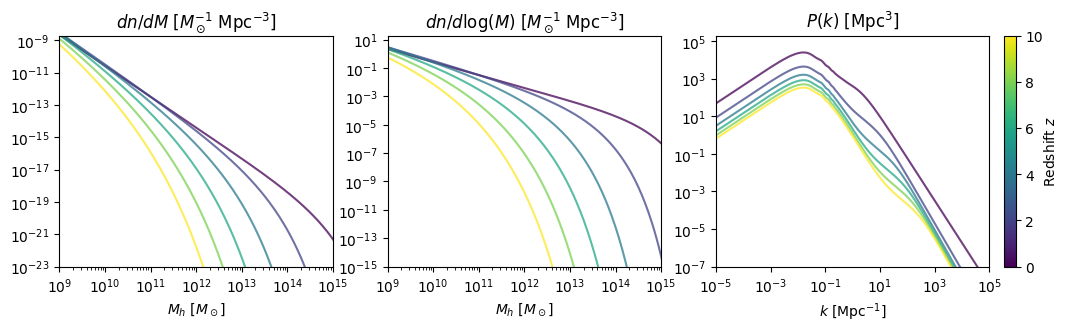

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharex=False, sharey=False)
z_display = np.array([0,2,4,6,8,10])
color = iter(cm.viridis(np.linspace(0,1,len(z_display))))
for z in tqdm(z_display):
    hmf_mass, hmf_dndm, hmf_nu, hmf_k, hmf_PS = HOD.init_lookup_table(z, 0, REWRITE_TBLS = 0)
    hmf_mass = hmf_mass * h
    hmf_dndm = hmf_dndm / h**4
    hmf_k  = hmf_k / h
    hmf_PS = hmf_PS * h**3
    _col_ = next(color)
    ax[0].plot(hmf_mass, hmf_dndm, c = _col_, ls = '-', alpha=0.75)
    ax[1].plot(hmf_mass, hmf_dndm*hmf_mass, c = _col_, ls = '-', alpha=0.75)
    ax[2].plot(hmf_k   , hmf_PS  , c = _col_, ls = '-', alpha=0.75)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$M_h$ [$M_\odot$]')
ax[0].set_title(r'$dn/dM$ [$M_\odot^{-1}$ Mpc$^{-3}$]')
ax[0].set_xlim((1e9,1e15))
ax[0].set_ylim((1e-23,2e-9))
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$M_h$ [$M_\odot$]')
ax[1].set_title(r'$dn/d\log(M)$ [$M_\odot^{-1}$ Mpc$^{-3}$]')
ax[1].set_xlim((1e9,1e15))
ax[1].set_ylim((1e-15,2e1))
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel(r'$k$ [Mpc$^{-1}$]')
ax[2].set_title(r'$P(k)$ [Mpc$^3$]')
ax[2].set_xlim((1e-5,1e5))
ax[2].set_ylim((1e-7,2e5))
p0 = ax[1].get_position().get_points().flatten()
ax_cbar = fig.add_axes([0.912, 0.11, 0.01, 0.77])
norm = NormColor(vmin=np.min(z_display),vmax=np.max(z_display))
s_m = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
s_m.set_array([])
cbar = plt.colorbar(s_m, cax=ax_cbar)
cbar.set_label(r'Redshift $z$', labelpad=0)
plt.show()

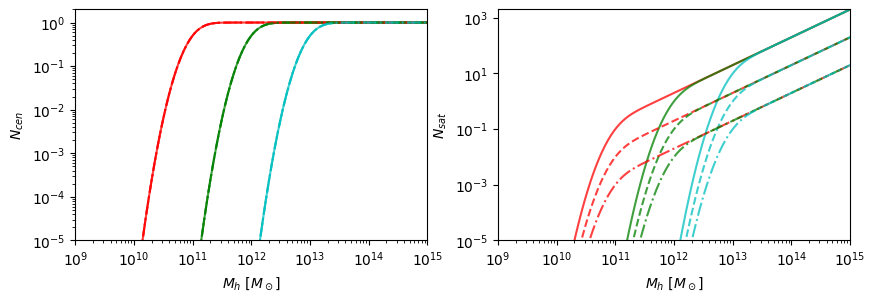

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharex=False, sharey=False)
z_display = np.array([0,2,4,6,8,10])
color = iter(cm.viridis(np.linspace(0,1,len(z_display))))
for M_sat, _ls in zip([5e11, 5e12, 5e13], ['-', '--', '-.']):
    for M_min, _c in zip([1e11, 1e12, 1e13], ['r', 'g', 'c']):
        Ncen = HOD.N_cen(hmf_mass, M_min, 0.2)
        Nsat = HOD.N_sat(hmf_mass, M_sat, 1, M_min, 0.2)
        ax[0].plot(hmf_mass, Ncen, c = _c, ls = _ls, alpha=0.75)
        ax[1].plot(hmf_mass, Nsat, c = _c, ls = _ls, alpha=0.75)
        # ax[0].axvline(M_min, c = _c,  alpha=0.4)
        # ax[1].axvline(M_min, c = _c,  alpha=0.4)
        # ax[0].axvline(M_sat, c = 'k', ls = _ls,  alpha=0.2)
        # ax[1].axvline(M_sat, c = 'k', ls = _ls,  alpha=0.2)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$M_h$ $[M_\odot]$')
ax[0].set_ylabel(r'$N_{cen}$')
ax[0].set_xlim((1e9,1e15))
ax[0].set_ylim((1e-5,2e0))
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$M_h$ $[M_\odot]$')
ax[1].set_ylabel(r'$N_{sat}$')
ax[1].set_xlim((1e9,1e15))
ax[1].set_ylim((1e-5,2e3))

plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

Calculating HMF table at redshift 10.00


KeyboardInterrupt: 

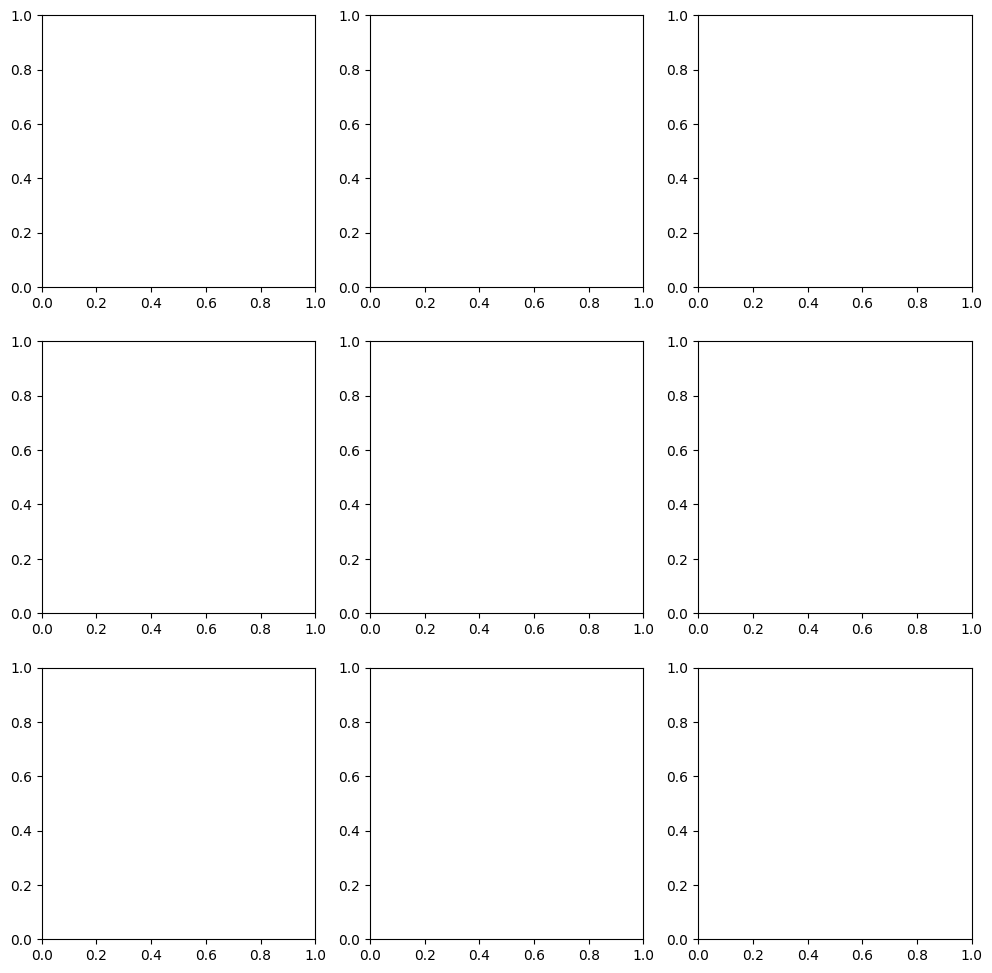

In [6]:
M_min, M_sat = 1e12, 1e13
theta = 10/206265

from scipy.integrate import simpson

def PS_1cs_1ss_2_terms(z, M_h_array, HMF_array, NCEN, NSAT, U_FT, bias):
    if U_FT is None:
        crit_dens_rescaled = (4/3*np.pi*cosmo.critical_density(z).value*200*2e40)
        U_FT = np.array([HOD.u_FT(k, M_h_array, z, crit_dens_rescaled) for k in hmf_k])
    PS1cs = np.trapz(HMF_array * NCEN * NSAT * U_FT, M_h_array) * 2
    PS1ss = np.trapz(HMF_array * NSAT * NSAT * U_FT * U_FT, M_h_array) * 1
    PS_2h = np.power(np.trapz((NCEN + NSAT) * HMF_array * bias * U_FT, M_h_array), 2)
    return np.array([PS1cs, PS1ss, PS_2h])
from halomod.bias import Tinker10

def check_integral_err(theta, z, P_1cs, P_1ss, PS_2h, Bessel, k_array, hmf_PS, STEP_J0 = 10_000):
    comoving_distance_z = cosmo.comoving_distance(z).value
    j_0_zeros = np.append(1e-4, special.jn_zeros(0, STEP_J0))
    res1cs, res1ss, res2cc = np.zeros(0), np.zeros(0), np.zeros(0)
    k0 = j_0_zeros / theta / comoving_distance_z
    mask_k = k_array < k0[0]
    k_intr = np.append(k_array[mask_k], k0[0])
    Bessel = np.array([special.j0(k*theta*comoving_distance_z) for k in k_array[mask_k]])
    int1cs = simpson(np.append(P_1cs[mask_k], 0)
                    * k_intr / (2*np.pi) * np.append(Bessel, 0), k_intr)
    int1ss = simpson(np.append(P_1ss[mask_k], 0)
                    * k_intr / (2*np.pi) * np.append(Bessel, 0), k_intr)
    int2cc = simpson(np.append(hmf_PS[mask_k], 0) * np.append(PS_2h[mask_k],0)
                    * k_intr / (2*np.pi) * np.append(Bessel, 0), k_intr)
    res1cs = np.append(res1cs, int1cs)
    res1ss = np.append(res1ss, int1ss)
    res2cc = np.append(res2cc, int2cc)
    for i in range(STEP_J0-1):
        mask_k = np.logical_and(k_array> k0[i], k_array< k0[i+1])
        k_intr = np.append(k0[i], np.append(k_array[mask_k], k0[i+1]))
        Bessel = np.array([special.j0(k*theta*comoving_distance_z) for k in k_array[mask_k]])
        int1cs = simpson(np.pad(P_1cs[mask_k], 1) * k_intr / (2*np.pi)
                            * np.pad(Bessel, 1), k_intr)
        int1ss = simpson(np.pad(P_1ss[mask_k], 1) * k_intr / (2*np.pi)
                            * np.pad(Bessel, 1), k_intr)
        int2cc = simpson(np.pad(hmf_PS[mask_k], 1) * np.pad(PS_2h[mask_k],1)
                            * k_intr / (2*np.pi) * np.pad(Bessel, 1), k_intr)
        res1cs = np.append(res1cs, int1cs)
        res1ss = np.append(res1ss, int1ss)
        res2cc = np.append(res2cc, int2cc)
    r1cs, r1ss, r2cc = np.sum(res1cs), np.sum(res1ss), np.sum(res2cc)
    e1cs = np.abs((r1cs - np.sum(res1cs[:-1]))/r1cs)
    e1ss = np.abs((r1ss - np.sum(res1ss[:-1]))/r1ss)
    e2cc = np.abs((r2cc - np.sum(res2cc[:-1]))/r2cc)
    print('#### z: ', z, ' ########################')
    print(f'Integral 1cs: {r1cs:.1e} \pm {e1cs:.1e}')
    print(f'Integral 1ss: {r1ss:.1e} \pm {e1ss:.1e}')
    print(f'Integral 2cc: {r2cc:.1e} \pm {e2cc:.1e}')
    return r1cs, r1ss, r2cc

fig, ax = plt.subplots(3, 3, figsize=(12, 12), sharex=False, sharey=False)
z_display = np.array([0.1, 2, 4, 6, 8, 10])
color = iter(cm.viridis(np.linspace(0,1,len(z_display))))
for z in tqdm(z_display[::-1]):
    comoving_distance_z = cosmo.comoving_distance(z).value
    M_h_array, HMF_array, hmf_nu, hmf_k, hmf_PS = HOD.init_lookup_table(z, 0, 0)
    U_FT = None
    NCEN = HOD.N_cen(M_h_array, M_min, 0.2)
    NSAT = HOD.N_sat(M_h_array, M_sat, 1, M_min, 0.2)
    crit_dens_rescaled = (4/3*np.pi*cosmo.critical_density(z).value*200*2e40)
    bias = Tinker10(nu=hmf_nu).bias()
    P_1cs, P_1ss, PS_2h = PS_1cs_1ss_2_terms(z, M_h_array, HMF_array, NCEN, NSAT, U_FT, bias)
    F = 1
    N1cs, N1ss, N2 = np.max(P_1cs)* F, np.max(P_1ss)* F, np.max(PS_2h)* F
    P_1cs, P_1ss, PS_2h = P_1cs/N1cs, P_1ss/N1ss, PS_2h/N2
    _c_ = next(color)
    ax[0, 0].plot(hmf_k, P_1cs, c=_c_)
    ax[0, 1].plot(hmf_k, P_1ss, c=_c_)
    ax[0, 2].plot(hmf_k, PS_2h, c=_c_)
    ax[1, 0].plot(hmf_k, P_1cs * hmf_k, c=_c_)
    ax[1, 1].plot(hmf_k, P_1ss * hmf_k, c=_c_)
    ax[1, 2].plot(hmf_k, PS_2h * hmf_k, c=_c_)
    Bessel = np.array([special.j0(k*theta*comoving_distance_z) for k in hmf_k])
    ax[2, 0].plot(hmf_k, P_1cs * hmf_k / (2*np.pi) * Bessel, c=_c_)
    ax[2, 1].plot(hmf_k, P_1ss * hmf_k / (2*np.pi) * Bessel, c=_c_)
    ax[2, 2].plot(hmf_k, PS_2h * hmf_k / (2*np.pi) * Bessel, c=_c_)
    R_T1cs, R_T1ss, R_T2 = check_integral_err(theta, z, P_1cs, P_1ss, PS_2h, Bessel, hmf_k, hmf_PS)


for j in range(3):
    ax[j, 0].set_xscale('log')
    ax[j, 0].set_yscale('log')
    ax[j, 0].set_xlabel(r'$k$ [Mpc$^{-1}]$')
    ax[j, 0].set_title(r'$P1_{cs}$')
    ax[j, 1].set_xscale('log')
    ax[j, 1].set_yscale('log')
    ax[j, 1].set_xlabel(r'$k$ [Mpc$^{-1}]$')
    ax[j, 1].set_title(r'$P1_{ss}$')
    ax[j, 2].set_xscale('log')
    ax[j, 2].set_yscale('log')
    ax[j, 2].set_xlabel(r'$k$ [Mpc$^{-1}]$')
    ax[j, 2].set_title(r'$P2$')
    ax[j, 0].set_ylim((1e-5,5e2))
    ax[j, 1].set_ylim((1e-5,5e2))
    ax[j, 2].set_ylim((1e-5,5e2))

p0 = ax[0,1].get_position().get_points().flatten()
ax_cbar = fig.add_axes([0.912, 0.11, 0.01, 0.77])
norm = NormColor(vmin=np.min(z_display*0),vmax=np.max(z_display))
s_m = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
s_m.set_array([])
cbar = plt.colorbar(s_m, cax=ax_cbar)
cbar.set_label(r'Redshift $z$', labelpad=0)
plt.show()

In [8]:
M_sat, M_min, sigma_logM, alpha = 10**13.0, 10**12.0, 0.2, 1.0
th_arr = np.logspace(-0.5, 3.5, 21)
LR = True
z = 1
data = [(z-0.2, 1/3),(z, 1/3),(z+0.2, 1/3)]
z_array, N_z_nrm = np.array(data).T
o1_1, o2_1 = HOD.omega(th_arr/206265, M_min, sigma_logM, M_sat, alpha, N_z_nrm, z_array, LOW_RES=LR)
print(z)
z = 3
data = [(z-0.2, 1/3),(z, 1/3),(z+0.2, 1/3)]
z_array, N_z_nrm = np.array(data).T
o1_3, o2_3 = HOD.omega(th_arr/206265, M_min, sigma_logM, M_sat, alpha, N_z_nrm, z_array, LOW_RES=LR)
print(z)
z = 5
data = [(z-0.2, 1/3),(z, 1/3),(z+0.2, 1/3)]
z_array, N_z_nrm = np.array(data).T
o1_5, o2_5 = HOD.omega(th_arr/206265, M_min, sigma_logM, M_sat, alpha, N_z_nrm, z_array, LOW_RES=LR)
print(z)
z = 7
data = [(z-0.2, 1/3),(z, 1/3),(z+0.2, 1/3)]
z_array, N_z_nrm = np.array(data).T
o1_7, o2_7 = HOD.omega(th_arr/206265, M_min, sigma_logM, M_sat, alpha, N_z_nrm, z_array, LOW_RES=LR)
print(z)
z = 9
data = [(z-0.2, 1/3),(z, 1/3),(z+0.2, 1/3)]
z_array, N_z_nrm = np.array(data).T
o1_9, o2_9 = HOD.omega(th_arr/206265, M_min, sigma_logM, M_sat, alpha, N_z_nrm, z_array, LOW_RES=LR)

1


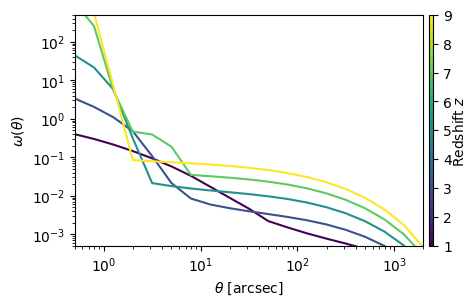

In [9]:
SHOW_HALO_TERMS = 0
_color_ = iter(cm.viridis(np.linspace(0,1,5)))

_o1 = np.copy(o1_1)
_o3 = np.copy(o1_3)
_o5 = np.copy(o1_5)
_o7 = np.copy(o1_7)
_o9 = np.copy(o1_9)

_o1[_o1<0] = 0
_o3[_o3<0] = 0
_o5[_o5<0] = 0
_o7[_o7<0] = 0
_o9[_o9<0] = 0
_o1[th_arr>=50] = 0
_o3[th_arr>=50] = 0
_o5[th_arr>=50] = 0
_o7[th_arr>=50] = 0
_o9[th_arr>=50] = 0

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), sharex=False, sharey=False)
_col_ = next(_color_)
ax.plot(th_arr, _o1+o2_1, c = _col_, ls = '-')
if SHOW_HALO_TERMS:
    ax.plot(th_arr, _o1     , c = _col_, ls = '--', label=r'$\omega_{1h}$')
    ax.plot(th_arr, o2_1    , c = _col_, ls = '-.', label=r'$\omega_{2h}$')
    ax.plot(th_arr, o1_1    , c = _col_, ls = '--', alpha=0.25)

_col_ = next(_color_)
ax.plot(th_arr, _o3+o2_3, c = _col_, ls = '-')
if SHOW_HALO_TERMS:
    ax.plot(th_arr, _o3     , c = _col_, ls = '--')
    ax.plot(th_arr, o2_3    , c = _col_, ls = '-.')
    ax.plot(th_arr, o1_3    , c = _col_, ls = '--', alpha=0.25)

_col_ = next(_color_)
ax.plot(th_arr, _o5+o2_5, c = _col_, ls = '-')
if SHOW_HALO_TERMS:
    ax.plot(th_arr, _o5     , c = _col_, ls = '--')
    ax.plot(th_arr, o2_5    , c = _col_, ls = '-.')
    ax.plot(th_arr, o1_5    , c = _col_, ls = '--', alpha=0.25)

_col_ = next(_color_)
ax.plot(th_arr, _o7+o2_7, c = _col_, ls = '-')
if SHOW_HALO_TERMS:
    ax.plot(th_arr, _o7     , c = _col_, ls = '--')
    ax.plot(th_arr, o2_7    , c = _col_, ls = '-.')
    ax.plot(th_arr, o1_7    , c = _col_, ls = '--', alpha=0.25)

_col_ = next(_color_)
ax.plot(th_arr, _o9+o2_9, c = _col_, ls = '-')
if SHOW_HALO_TERMS:
    ax.plot(th_arr, _o9     , c = _col_, ls = '--')
    ax.plot(th_arr, o2_9    , c = _col_, ls = '-.')
    ax.plot(th_arr, o1_9    , c = _col_, ls = '--', alpha=0.25)

p0 = ax.get_position().get_points().flatten()
ax_cbar = fig.add_axes([0.912, 0.11, 0.01, 0.77])
norm = NormColor(vmin=1,vmax=9)
s_m = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
s_m.set_array([])
cbar = plt.colorbar(s_m, cax=ax_cbar)
cbar.set_label(r'Redshift $z$', labelpad=0)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((0.5,2e3))
ax.set_ylim((5e-4, 5e2))
ax.set_xlabel(r'$\theta$ [arcsec]')
ax.set_ylabel(r'$\omega$($\theta$)')
# plt.legend()
plt.show()

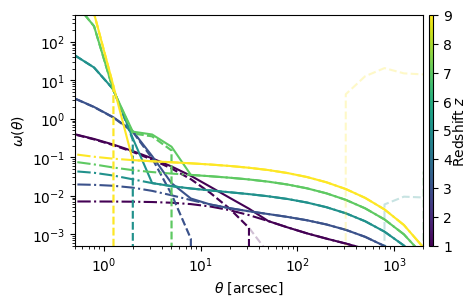

In [5]:
SHOW_HALO_TERMS = 1
_color_ = iter(cm.viridis(np.linspace(0,1,5)))

_o1 = np.copy(o1_1)
_o3 = np.copy(o1_3)
_o5 = np.copy(o1_5)
_o7 = np.copy(o1_7)
_o9 = np.copy(o1_9)

_o1[_o1<0] = 0
_o3[_o3<0] = 0
_o5[_o5<0] = 0
_o7[_o7<0] = 0
_o9[_o9<0] = 0
_o1[th_arr>=50] = 0
_o3[th_arr>=50] = 0
_o5[th_arr>=50] = 0
_o7[th_arr>=50] = 0
_o9[th_arr>=50] = 0

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), sharex=False, sharey=False)
_col_ = next(_color_)
ax.plot(th_arr, _o1+o2_1, c = _col_, ls = '-')
if SHOW_HALO_TERMS:
    ax.plot(th_arr, _o1     , c = _col_, ls = '--', label=r'$\omega_{1h}$')
    ax.plot(th_arr, o2_1    , c = _col_, ls = '-.', label=r'$\omega_{2h}$')
    ax.plot(th_arr, o1_1    , c = _col_, ls = '--', alpha=0.25)

_col_ = next(_color_)
ax.plot(th_arr, _o3+o2_3, c = _col_, ls = '-')
if SHOW_HALO_TERMS:
    ax.plot(th_arr, _o3     , c = _col_, ls = '--')
    ax.plot(th_arr, o2_3    , c = _col_, ls = '-.')
    ax.plot(th_arr, o1_3    , c = _col_, ls = '--', alpha=0.25)

_col_ = next(_color_)
ax.plot(th_arr, _o5+o2_5, c = _col_, ls = '-')
if SHOW_HALO_TERMS:
    ax.plot(th_arr, _o5     , c = _col_, ls = '--')
    ax.plot(th_arr, o2_5    , c = _col_, ls = '-.')
    ax.plot(th_arr, o1_5    , c = _col_, ls = '--', alpha=0.25)

_col_ = next(_color_)
ax.plot(th_arr, _o7+o2_7, c = _col_, ls = '-')
if SHOW_HALO_TERMS:
    ax.plot(th_arr, _o7     , c = _col_, ls = '--')
    ax.plot(th_arr, o2_7    , c = _col_, ls = '-.')
    ax.plot(th_arr, o1_7    , c = _col_, ls = '--', alpha=0.25)

_col_ = next(_color_)
ax.plot(th_arr, _o9+o2_9, c = _col_, ls = '-')
if SHOW_HALO_TERMS:
    ax.plot(th_arr, _o9     , c = _col_, ls = '--')
    ax.plot(th_arr, o2_9    , c = _col_, ls = '-.')
    ax.plot(th_arr, o1_9    , c = _col_, ls = '--', alpha=0.25)

p0 = ax.get_position().get_points().flatten()
ax_cbar = fig.add_axes([0.912, 0.11, 0.01, 0.77])
norm = NormColor(vmin=1,vmax=9)
s_m = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
s_m.set_array([])
cbar = plt.colorbar(s_m, cax=ax_cbar)
cbar.set_label(r'Redshift $z$', labelpad=0)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((0.5,2e3))
ax.set_ylim((5e-4, 5e2))
ax.set_xlabel(r'$\theta$ [arcsec]')
ax.set_ylabel(r'$\omega$($\theta$)')
# plt.legend()
plt.show()

In [ ]:
z = 7
data = [(z-0.2, 1/3),(z, 1/3),(z+0.2, 1/3)]
z_array, N_z_nrm = np.array(data).T

M_sat, M_min, sigma_logM, alpha = 10**12.0, 10**11.0, 0.2, 1.0
o1_A, o2_A = HOD.omega(th_arr/206265, M_min, sigma_logM, M_sat, alpha, N_z_nrm, z_array, REWRITE_TBLS=0)

M_sat, M_min, sigma_logM, alpha = 10**13.0, 10**11.0, 0.2, 1.0
o1_B, o2_B = HOD.omega(th_arr/206265, M_min, sigma_logM, M_sat, alpha, N_z_nrm, z_array, REWRITE_TBLS=0)

M_sat, M_min, sigma_logM, alpha = 10**14.0, 10**11.0, 0.2, 1.0
o1_C, o2_C = HOD.omega(th_arr/206265, M_min, sigma_logM, M_sat, alpha, N_z_nrm, z_array, REWRITE_TBLS=0)

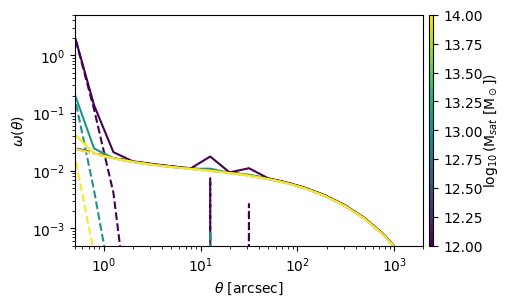

In [ ]:
SHOW_HALO_TERMS = 1
_color_ = iter(cm.viridis(np.linspace(0,1,3)))

_oA = np.copy(o1_A)
_oB = np.copy(o1_B)
_oC = np.copy(o1_C)

_oA[_oA<0] = 0
_oB[_oB<0] = 0
_oC[_oC<0] = 0
_oA[th_arr>=50] = 0
_oB[th_arr>=50] = 0
_oC[th_arr>=50] = 0


fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), sharex=False, sharey=False)
_col_ = next(_color_)
ax.plot(th_arr, _oA+o2_A, c = _col_, ls = '-')
if SHOW_HALO_TERMS:
    ax.plot(th_arr, _oA     , c = _col_, ls = '--', label=r'$\omega_{1h}$')
    ax.plot(th_arr, o2_A    , c = _col_, ls = '-.', label=r'$\omega_{2h}$')
    # ax.plot(th_arr, o1_A    , c = _col_, ls = '--', alpha=0.25)

_col_ = next(_color_)
ax.plot(th_arr, _oB+o2_B, c = _col_, ls = '-')
if SHOW_HALO_TERMS:
    ax.plot(th_arr, _oB     , c = _col_, ls = '--')
    ax.plot(th_arr, o2_B    , c = _col_, ls = '-.')
    # ax.plot(th_arr, o1_B    , c = _col_, ls = '--', alpha=0.25)

_col_ = next(_color_)
ax.plot(th_arr, _oC+o2_C, c = _col_, ls = '-')
if SHOW_HALO_TERMS:
    ax.plot(th_arr, _oC     , c = _col_, ls = '--')
    ax.plot(th_arr, o2_C    , c = _col_, ls = '-.')
    # ax.plot(th_arr, o1_C    , c = _col_, ls = '--', alpha=0.25)

p0 = ax.get_position().get_points().flatten()
ax_cbar = fig.add_axes([0.912, 0.11, 0.01, 0.77])
norm = NormColor(vmin=12,vmax=14)
s_m = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
s_m.set_array([])
cbar = plt.colorbar(s_m, cax=ax_cbar)
cbar.set_label(r'$\log_{10}$(M$_{sat}$ [M$_\odot$])', labelpad=0)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((0.5,2e3))
ax.set_ylim((5e-4, 5))
ax.set_xlabel(r'$\theta$ [arcsec]')
ax.set_ylabel(r'$\omega$($\theta$)')
# plt.legend()
plt.show()

In [ ]:
z = 5
data = [(z-0.2, 1/3),(z, 1/3),(z+0.2, 1/3)]
z_array, N_z_nrm = np.array(data).T

M_sat, M_min, sigma_logM, alpha = 10**14.0, 10**11.0, 0.2, 1.0
o1_Y, o2_Y = HOD.omega(th_arr/206265, M_min, sigma_logM, M_sat, alpha, N_z_nrm, z_array, REWRITE_TBLS=0)

M_sat, M_min, sigma_logM, alpha = 10**14.0, 10**12.0, 0.2, 1.0
o1_X, o2_X = HOD.omega(th_arr/206265, M_min, sigma_logM, M_sat, alpha, N_z_nrm, z_array, REWRITE_TBLS=0)

M_sat, M_min, sigma_logM, alpha = 10**14.0, 10**13.0, 0.2, 1.0
o1_Z, o2_Z = HOD.omega(th_arr/206265, M_min, sigma_logM, M_sat, alpha, N_z_nrm, z_array, REWRITE_TBLS=0)

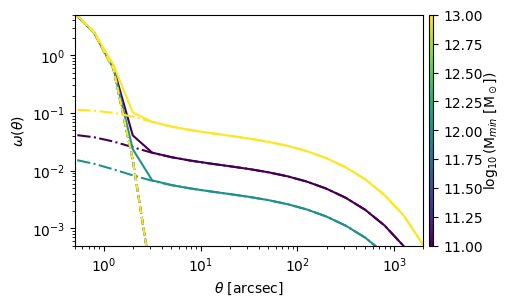

In [ ]:
SHOW_HALO_TERMS = 1
_color_ = iter(cm.viridis(np.linspace(0,1,3)))

_oX = np.copy(o1_X)
_oY = np.copy(o1_X)
_oZ = np.copy(o1_X)

_oX[_oX<0] = 0
_oY[_oY<0] = 0
_oZ[_oZ<0] = 0
_oX[th_arr>=50] = 0
_oY[th_arr>=50] = 0
_oZ[th_arr>=50] = 0


fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), sharex=False, sharey=False)
_col_ = next(_color_)
ax.plot(th_arr, _oX+o2_X, c = _col_, ls = '-')
if SHOW_HALO_TERMS:
    ax.plot(th_arr, _oX     , c = _col_, ls = '--', label=r'$\omega_{1h}$')
    ax.plot(th_arr, o2_X    , c = _col_, ls = '-.', label=r'$\omega_{2h}$')
    # ax.plot(th_arr, o1_X    , c = _col_, ls = '--', alpha=0.25)

_col_ = next(_color_)
ax.plot(th_arr, _oX+o2_Y, c = _col_, ls = '-')
if SHOW_HALO_TERMS:
    ax.plot(th_arr, _oY     , c = _col_, ls = '--')
    ax.plot(th_arr, o2_Y    , c = _col_, ls = '-.')
    # ax.plot(th_arr, o1_Y    , c = _col_, ls = '--', alpha=0.25)

_col_ = next(_color_)
ax.plot(th_arr, _oZ+o2_Z, c = _col_, ls = '-')
if SHOW_HALO_TERMS:
    ax.plot(th_arr, _oZ     , c = _col_, ls = '--')
    ax.plot(th_arr, o2_Z    , c = _col_, ls = '-.')
    # ax.plot(th_arr, o1_Z    , c = _col_, ls = '--', alpha=0.25)

p0 = ax.get_position().get_points().flatten()
ax_cbar = fig.add_axes([0.912, 0.11, 0.01, 0.77])
norm = NormColor(vmin=11,vmax=13)
s_m = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
s_m.set_array([])
cbar = plt.colorbar(s_m, cax=ax_cbar)
cbar.set_label(r'$\log_{10}$(M$_{min}$ [M$_\odot$])', labelpad=0)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((0.5,2e3))
ax.set_ylim((5e-4, 5))
ax.set_xlabel(r'$\theta$ [arcsec]')
ax.set_ylabel(r'$\omega$($\theta$)')
# plt.legend()

plt.show()

Calculating HMF table at redshift 0.00
Calculating HMF table at redshift 5.12
Calculating HMF table at redshift 5.37
Calculating HMF table at redshift 5.62
Calculating HMF table at redshift 5.87


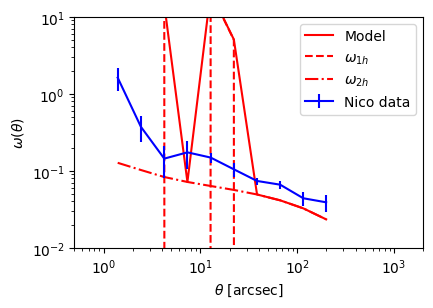

In [ ]:
M_sat, M_min, sigma_logM, alpha = 10**13.5, 10**13.0, 0.2, 1.0

zz = np.array([5.    , 5.2475, 5.495 , 5.7425, 5.99  ])
z_array = (zz[:-1] + zz[1:]) / 2
N = np.array([448, 451, 641, 535])
w_obs = np.array([1.62159772, 0.37306552, 0.14413575, 0.17384627, 0.14877287, 0.10469127, 0.07389844, 0.06610705, 0.04405596, 0.03900939])
w_err = np.array([0.52663385, 0.13507835, 0.06413887, 0.06794559, 0.0229982 , 0.02041773, 0.00789723, 0.00806796, 0.00878693, 0.00962475])

bin_centre = np.array([  1.3977544 ,   2.42791058,   4.23306435,   7.33872431, 12.74758672,
                         22.14320549,  38.43186415,  66.63374299,115.39951339, 198.93851897])
# plt.errorbar(bin_centre,w_obs, w_err, c='b')

N_norm = N / (np.sum(N))# * np.diff(zz)[0])
t_Nico = bin_centre/206265.

o1_N, o2_N = HOD.omega(t_Nico, M_min, sigma_logM, M_sat, alpha, N_norm, z_array, REWRITE_TBLS=1)

SHOW_HALO_TERMS = 1
_oN = np.copy(o1_N)
_oN[_oN<0] = 0
_oN[bin_centre>=35] = 0
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), sharex=False, sharey=False)
ax.plot(bin_centre, _oN+o2_N, c = 'r', ls = '-', label='Model')
if SHOW_HALO_TERMS:
    ax.plot(bin_centre, _oN     , c = 'r', ls = '--', label=r'$\omega_{1h}$')
    ax.plot(bin_centre, o2_N    , c = 'r', ls = '-.', label=r'$\omega_{2h}$')
ax.errorbar(bin_centre,w_obs, w_err, c='b', label='Nico data')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((0.5,2e3))
ax.set_ylim((1e-2, 1e1))
ax.set_xlabel(r'$\theta$ [arcsec]')
ax.set_ylabel(r'$\omega$($\theta$)')
plt.legend()
plt.show()


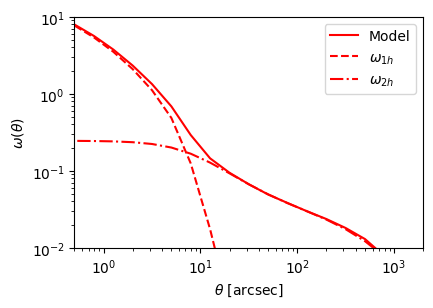

In [ ]:
z = 1.7
M_sat, M_min, sigma_logM, alpha = 10**14.18, 10**12.46, 0.2, 1.0
z_array = np.array([1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1])
N_z_nrm = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

th_arr = np.logspace(-0.5, 3.5, 21)
o1_N, o2_N = HOD.omega(th_arr/206265, M_min, sigma_logM, M_sat, alpha, N_z_nrm, z_array, PRECOMP_UFT = 0, REWRITE_TBLS=0)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), sharex=False, sharey=False)
ax.plot(th_arr, o1_N+o2_N, c = 'r', ls = '-', label='Model')
if 1:
    ax.plot(th_arr, o1_N, c = 'r', ls = '--', label=r'$\omega_{1h}$')
    ax.plot(th_arr, o2_N, c = 'r', ls = '-.', label=r'$\omega_{2h}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((0.5,2e3))
ax.set_ylim((1e-2, 1e1))
ax.set_xlabel(r'$\theta$ [arcsec]')
ax.set_ylabel(r'$\omega$($\theta$)')
plt.legend()

plt.show()

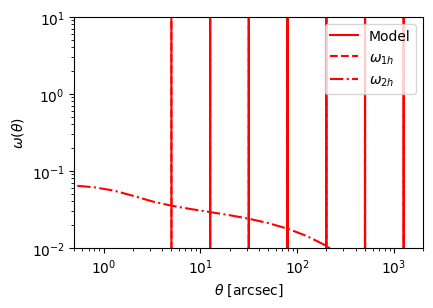

In [ ]:
z = 5.9
M_sat, M_min, sigma_logM, alpha = 10**11.73, 10**13.09, 0.2, 1.0
data = [
(5.500000e+00, 2.321580e-02),
(5.600000e+00, 5.284060e-02),
(5.700000e+00, 1.436010e-01),
(5.800000e+00, 1.481370e-01),
(5.900000e+00, 1.036900e-01),
(6.000000e+00, 1.342000e-01),
(6.100000e+00, 2.453660e-01),
(6.200000e+00, 1.546640e-01),
(6.300000e+00, 1.127430e-02)
]
z_array, N_z_nrm = np.array(data).T

th_arr = np.logspace(-0.5, 3.5, 21)
o1_N, o2_N = HOD.omega(th_arr/206265, M_min, sigma_logM, M_sat, alpha, N_z_nrm/np.sum(N_z_nrm), z_array, REWRITE_TBLS=0)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), sharex=False, sharey=False)
ax.plot(th_arr, o1_N+o2_N, c = 'r', ls = '-', label='Model')
if 1:
    ax.plot(th_arr, o1_N     , c = 'r', ls = '--', label=r'$\omega_{1h}$')
    ax.plot(th_arr, o2_N    , c = 'r', ls = '-.', label=r'$\omega_{2h}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((0.5,2e3))
ax.set_ylim((1e-2, 1e1))
ax.set_xlabel(r'$\theta$ [arcsec]')
ax.set_ylabel(r'$\omega$($\theta$)')
plt.legend()

plt.show()